In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

Setup GPU

In [ ]:
!nvidia-smi

Tue May 21 23:38:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:0A:00.0  On |                  N/A |
| 44%   55C    P0             95W /  320W |    1222MiB /  10240MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
cuda = torch.cuda.is_available()

#GPU Setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    cuda = True
    print('Using: ' + str(torch.cuda.get_device_name(device)))
else:
    cuda = False
    print('Using: CPU')

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Using: NVIDIA GeForce RTX 3080


#Loading and Mapping Dataset

In [ ]:
name_input='francesco'

if name_input.lower() == 'francesco':
    dataset_unhealthy='/content/drive/MyDrive/Progetti_Uni/BCI Signal Reconstruction Projects (Napoli)/Dataset/EEG_Dataset_Final/Unhealthy'
    dataset_healthy='/content/drive/MyDrive/Progetti_Uni/BCI Signal Reconstruction Projects (Napoli)/Dataset/EEG_Dataset_Final/Healthy'


elif name_input.lower() == 'giuseppe':
    dataset_unhealthy=''
    dataset_healthy=''

elif name_input.lower() == 'francesco-local':
    dataset_unhealthy='/Users/franc/OneDrive/Desktop/AI & Robotics/Project/Napoli/EEG_Dataset_Final/Unhealthy'
    dataset_healthy='/Users/franc/OneDrive/Desktop/AI & Robotics/Project/Napoli/EEG_Dataset_Final/Healthy'

else:
    print('Invalid name, path not set!!')

print(dataset_unhealthy)
print(dataset_healthy)

#function to select the tsv file
def select_random_tsv(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tsv'):
                return os.path.join(root, file)
    return None

# Iterate through each file in the directory
def MyDataset(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    dataframes = []
    labels = []

    for file in csv_files:
        # Extract label from the filename
        label = os.path.splitext(file)[0]
        read_csv = os.path.join(directory, file)
        #Read csv file deleting the last column
        csv_file = pd.read_csv(read_csv, header=None).iloc[:, :-1]
        #Take a random tsv file from directory
        random_tsv_file = select_random_tsv(directory)
        #Read the tsv file
        tsv_df = pd.read_csv(random_tsv_file, sep='\t', header=None)
        # Exclude the first row
        first_column_tsv = tsv_df.iloc[1:, 0]
        first_column_tsv_truncated = first_column_tsv[:len(csv_file.iloc[0, :])]
        # Replace the first row of the CSV DataFrame with the first column of the TSV DataFrame
        csv_file.iloc[0, :] = first_column_tsv_truncated.values

        dataframes.append(csv_file)
        labels.append(label)

    return dataframes, labels

def print_dataframes_with_labels(dataframes, labels):
    #Print each dataframe along with its corresponding label.
    if len(dataframes) != len(labels):
        raise ValueError("The number of dataframes and labels must be equal.")

    for dataframe, label in zip(dataframes, labels):
        print("Label:", label)
        print("Dataframe:")
        print(dataframe)
        print("------------------")

/content/drive/MyDrive/Progetti_Uni/BCI Signal Reconstruction Projects (Napoli)/Dataset/EEG_Dataset_Final/Unhealthy
/content/drive/MyDrive/Progetti_Uni/BCI Signal Reconstruction Projects (Napoli)/Dataset/EEG_Dataset_Final/Healthy


Healthy & Unhealthy Dataframe

In [ ]:
#Transform the dataset in dataframe
unhealthy_dataframe,labels_unhealthy = MyDataset(dataset_unhealthy)
healthy_dataframe,labels_healthy = MyDataset(dataset_healthy)

#Print each Dataframe
print_dataframes_with_labels(unhealthy_dataframe, labels_unhealthy)
print_dataframes_with_labels(healthy_dataframe, labels_healthy)

Label: S4E2
Dataframe:
             0           1           2          3           4          5   \
0            C3          C4          Cz        CP1         CP2        CP5   
1      -5.52678   -11.60106   -5.546195  -8.751906   -13.32549  -10.01111   
2     -6.470226    9.689226   -5.541873   -10.2841    -10.1485  -10.07728   
3      -2.42065   -11.44363   -4.255825  -5.902369   -11.41145  -4.855661   
4     -3.542554   -5.029718   -2.719698  -5.995324   -8.914045  -8.511596   
...         ...         ...         ...        ...         ...        ...   
1991  -3.162015  -0.4541241  -0.0178844   -3.16568    3.563286   -7.71012   
1992  -3.904326  -0.8943371   -1.732591  -3.858181   -1.228374  -6.315442   
1993  -6.916084   0.4364339   -2.253073  -6.625514   -1.770201  -9.655405   
1994  -5.812485   0.4193881  -0.7681356  -5.414212   0.0923062  -8.974181   
1995  -1.848326  -0.3751442  -0.2907446  -1.068501  -0.7696371    -2.5155   

             6            7           8          9  

Filter dataframe with the common channels in each Dataset

In [ ]:
def score_and_find_common(list1, list2):
    common_elements = []

    # Convert all elements in list2 to lowercase for case-insensitive comparison
    lower_list2 = [element.lower() for element in list2]

    for element in list1:
        if element.lower() in lower_list2:
            common_elements.append(element)

    return common_elements

def filter_dataframe(df, common_channels):
    # Convert the common channels list to lowercase
    common_channels_lower = [channel.lower() for channel in common_channels]

    # Filter columns based on lowercase channel names
    df_filtered = df.loc[:, df.iloc[0].str.lower().isin(common_channels_lower)]

    return df_filtered


def remove_channels(dataframe):
  dataframes=[]
  tsv_healthy=select_random_tsv(dataset_healthy)
  tsv_unhealthy= select_random_tsv(dataset_unhealthy)
  common_channels=[]
  #Read the tsv file
  tsv_df_healthy = pd.read_csv(tsv_healthy, sep='\t', header=None)
  tsv_df_unhealthy = pd.read_csv(tsv_unhealthy, sep='\t', header=None)
  # Exclude the first row
  first_column_healthy = tsv_df_healthy.iloc[1:, 0]
  first_column_unhealthy = tsv_df_unhealthy.iloc[1:, 0]
  common_channels= score_and_find_common(first_column_healthy, first_column_unhealthy)
  for df in dataframe:
    # Filter the DataFrame to keep only the desired columns
    df_filtered = filter_dataframe(df, common_channels)
    dataframes.append(df_filtered)

  return dataframes

unhealthy_dataframe=remove_channels(unhealthy_dataframe)
healthy_dataframe=remove_channels(healthy_dataframe)

print_dataframes_with_labels(unhealthy_dataframe, labels_unhealthy)
print_dataframes_with_labels(healthy_dataframe, labels_healthy)

Label: S4E2
Dataframe:
             0           1           2          3           4          5   \
0            C3          C4          Cz        CP1         CP2        CP5   
1      -5.52678   -11.60106   -5.546195  -8.751906   -13.32549  -10.01111   
2     -6.470226    9.689226   -5.541873   -10.2841    -10.1485  -10.07728   
3      -2.42065   -11.44363   -4.255825  -5.902369   -11.41145  -4.855661   
4     -3.542554   -5.029718   -2.719698  -5.995324   -8.914045  -8.511596   
...         ...         ...         ...        ...         ...        ...   
1991  -3.162015  -0.4541241  -0.0178844   -3.16568    3.563286   -7.71012   
1992  -3.904326  -0.8943371   -1.732591  -3.858181   -1.228374  -6.315442   
1993  -6.916084   0.4364339   -2.253073  -6.625514   -1.770201  -9.655405   
1994  -5.812485   0.4193881  -0.7681356  -5.414212   0.0923062  -8.974181   
1995  -1.848326  -0.3751442  -0.2907446  -1.068501  -0.7696371    -2.5155   

             6            7           8          9  

Plot the normal signal

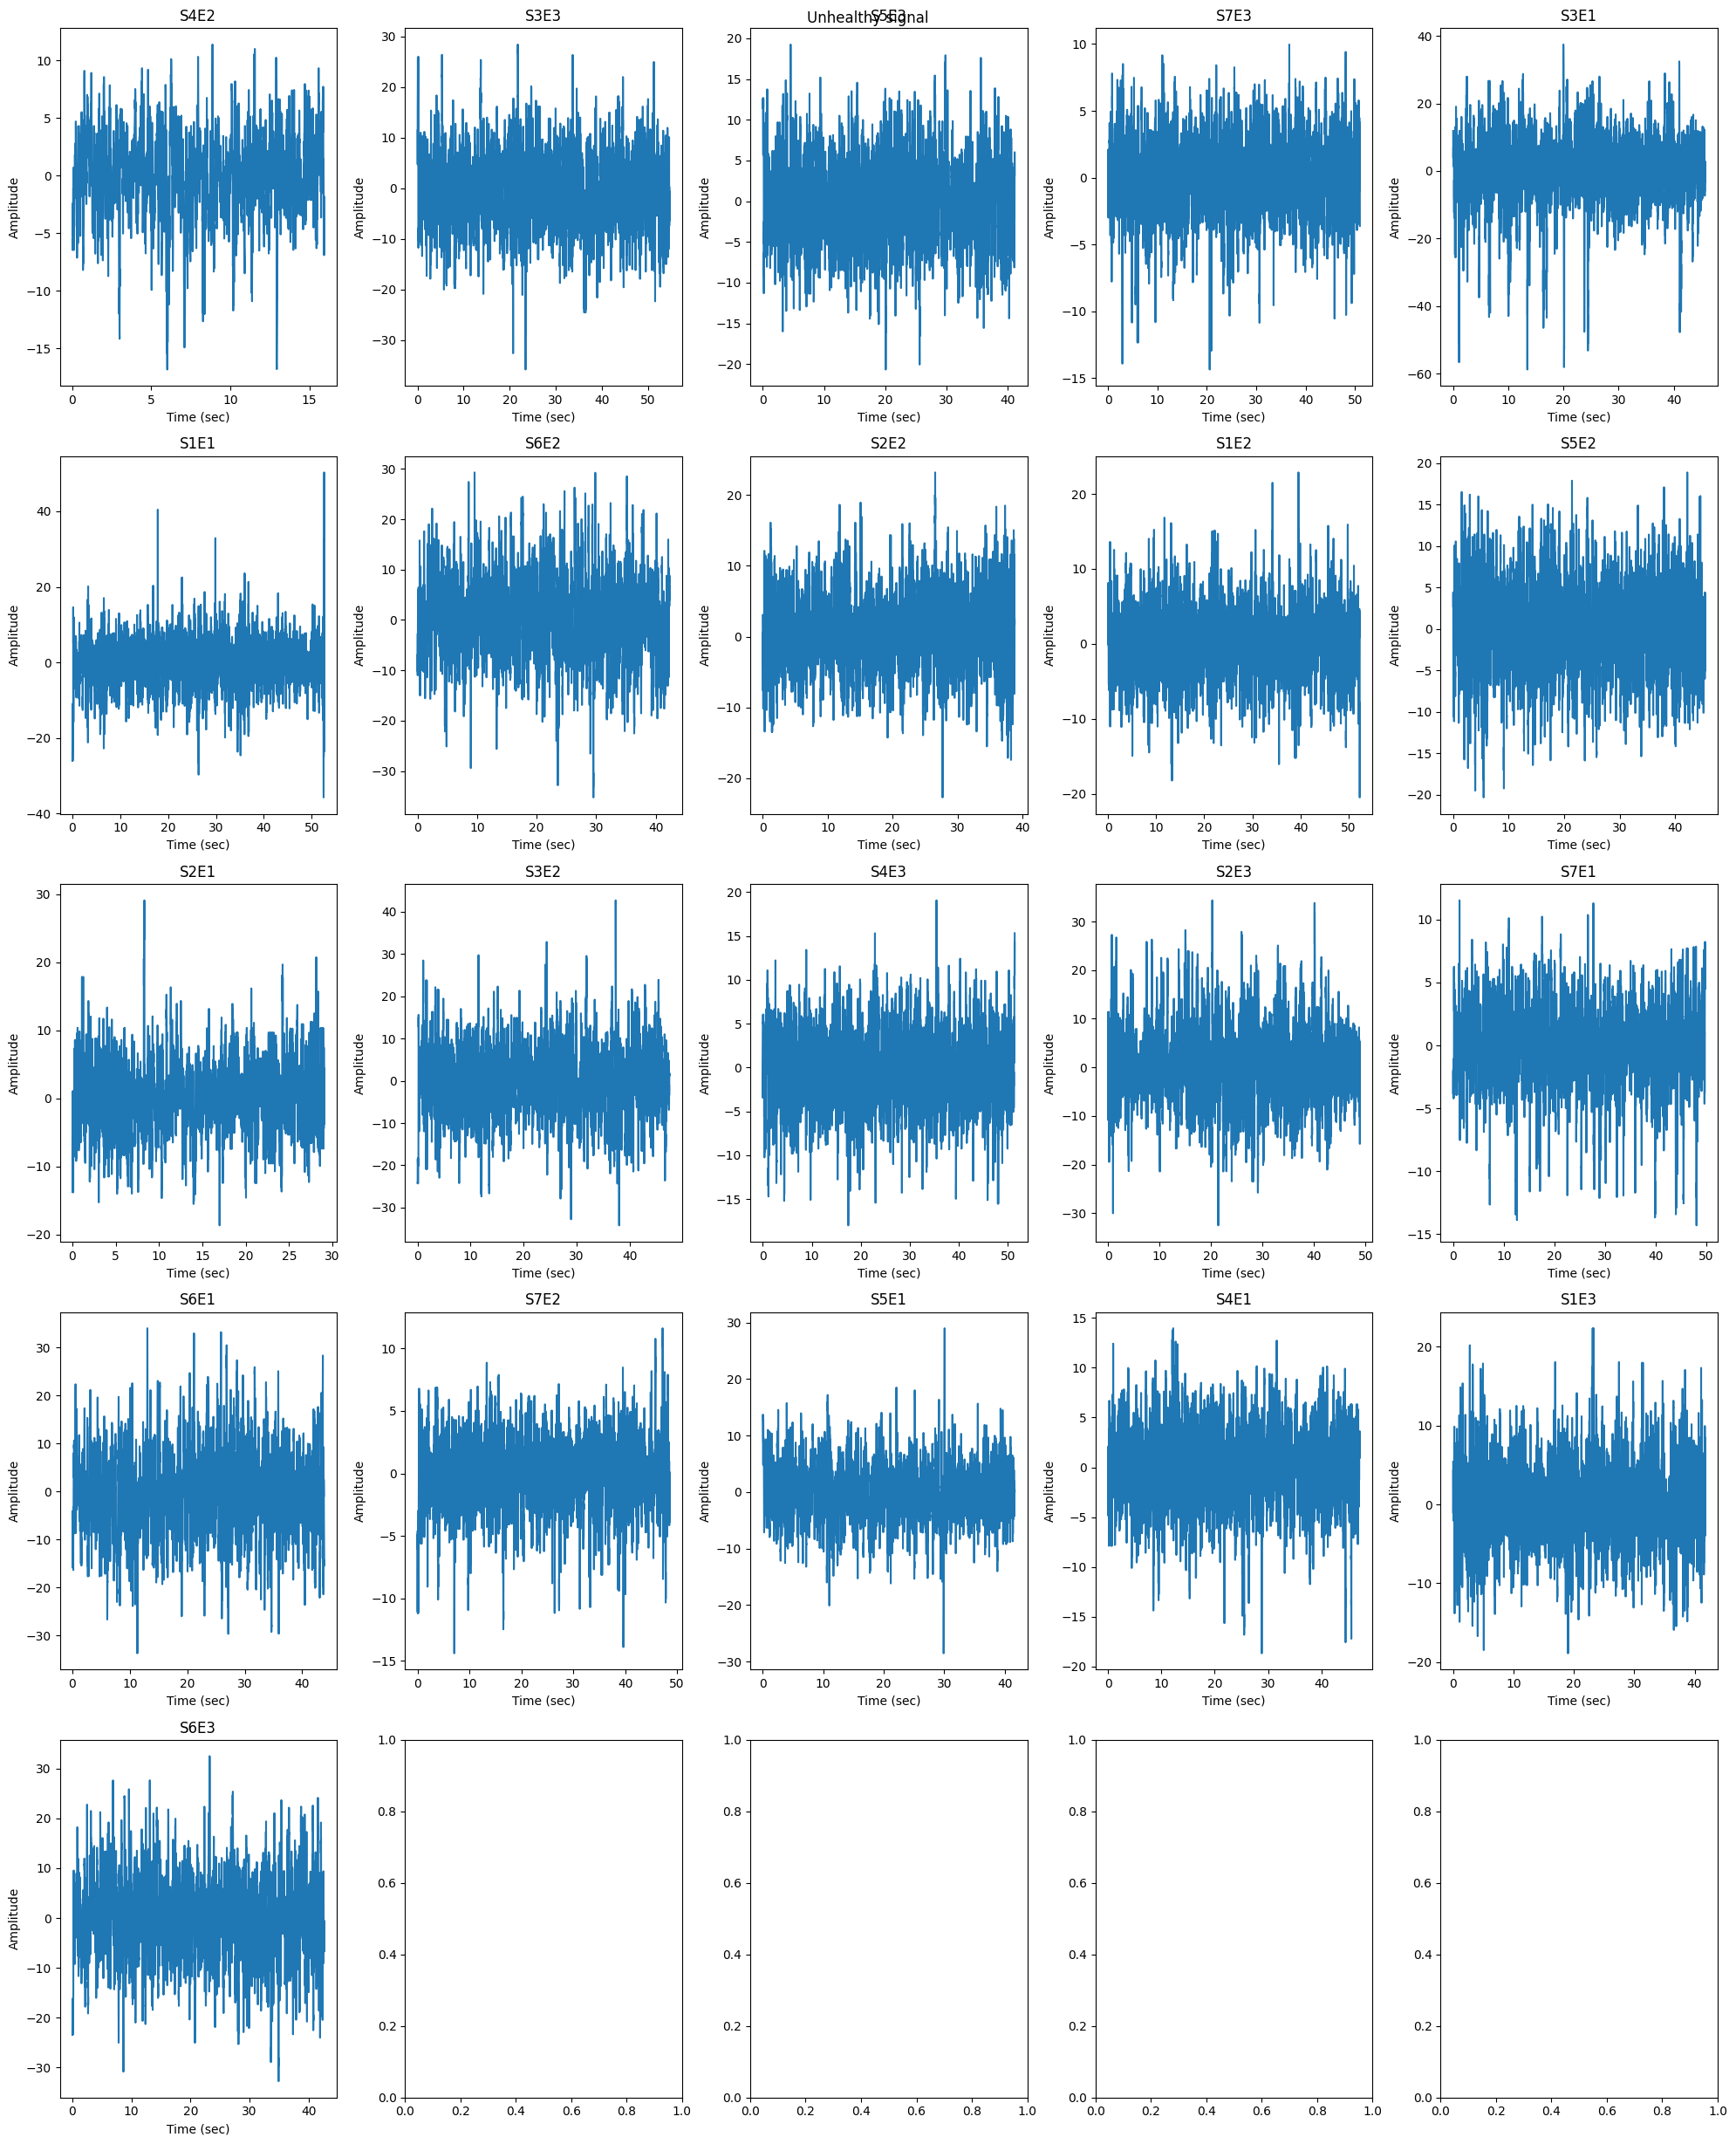

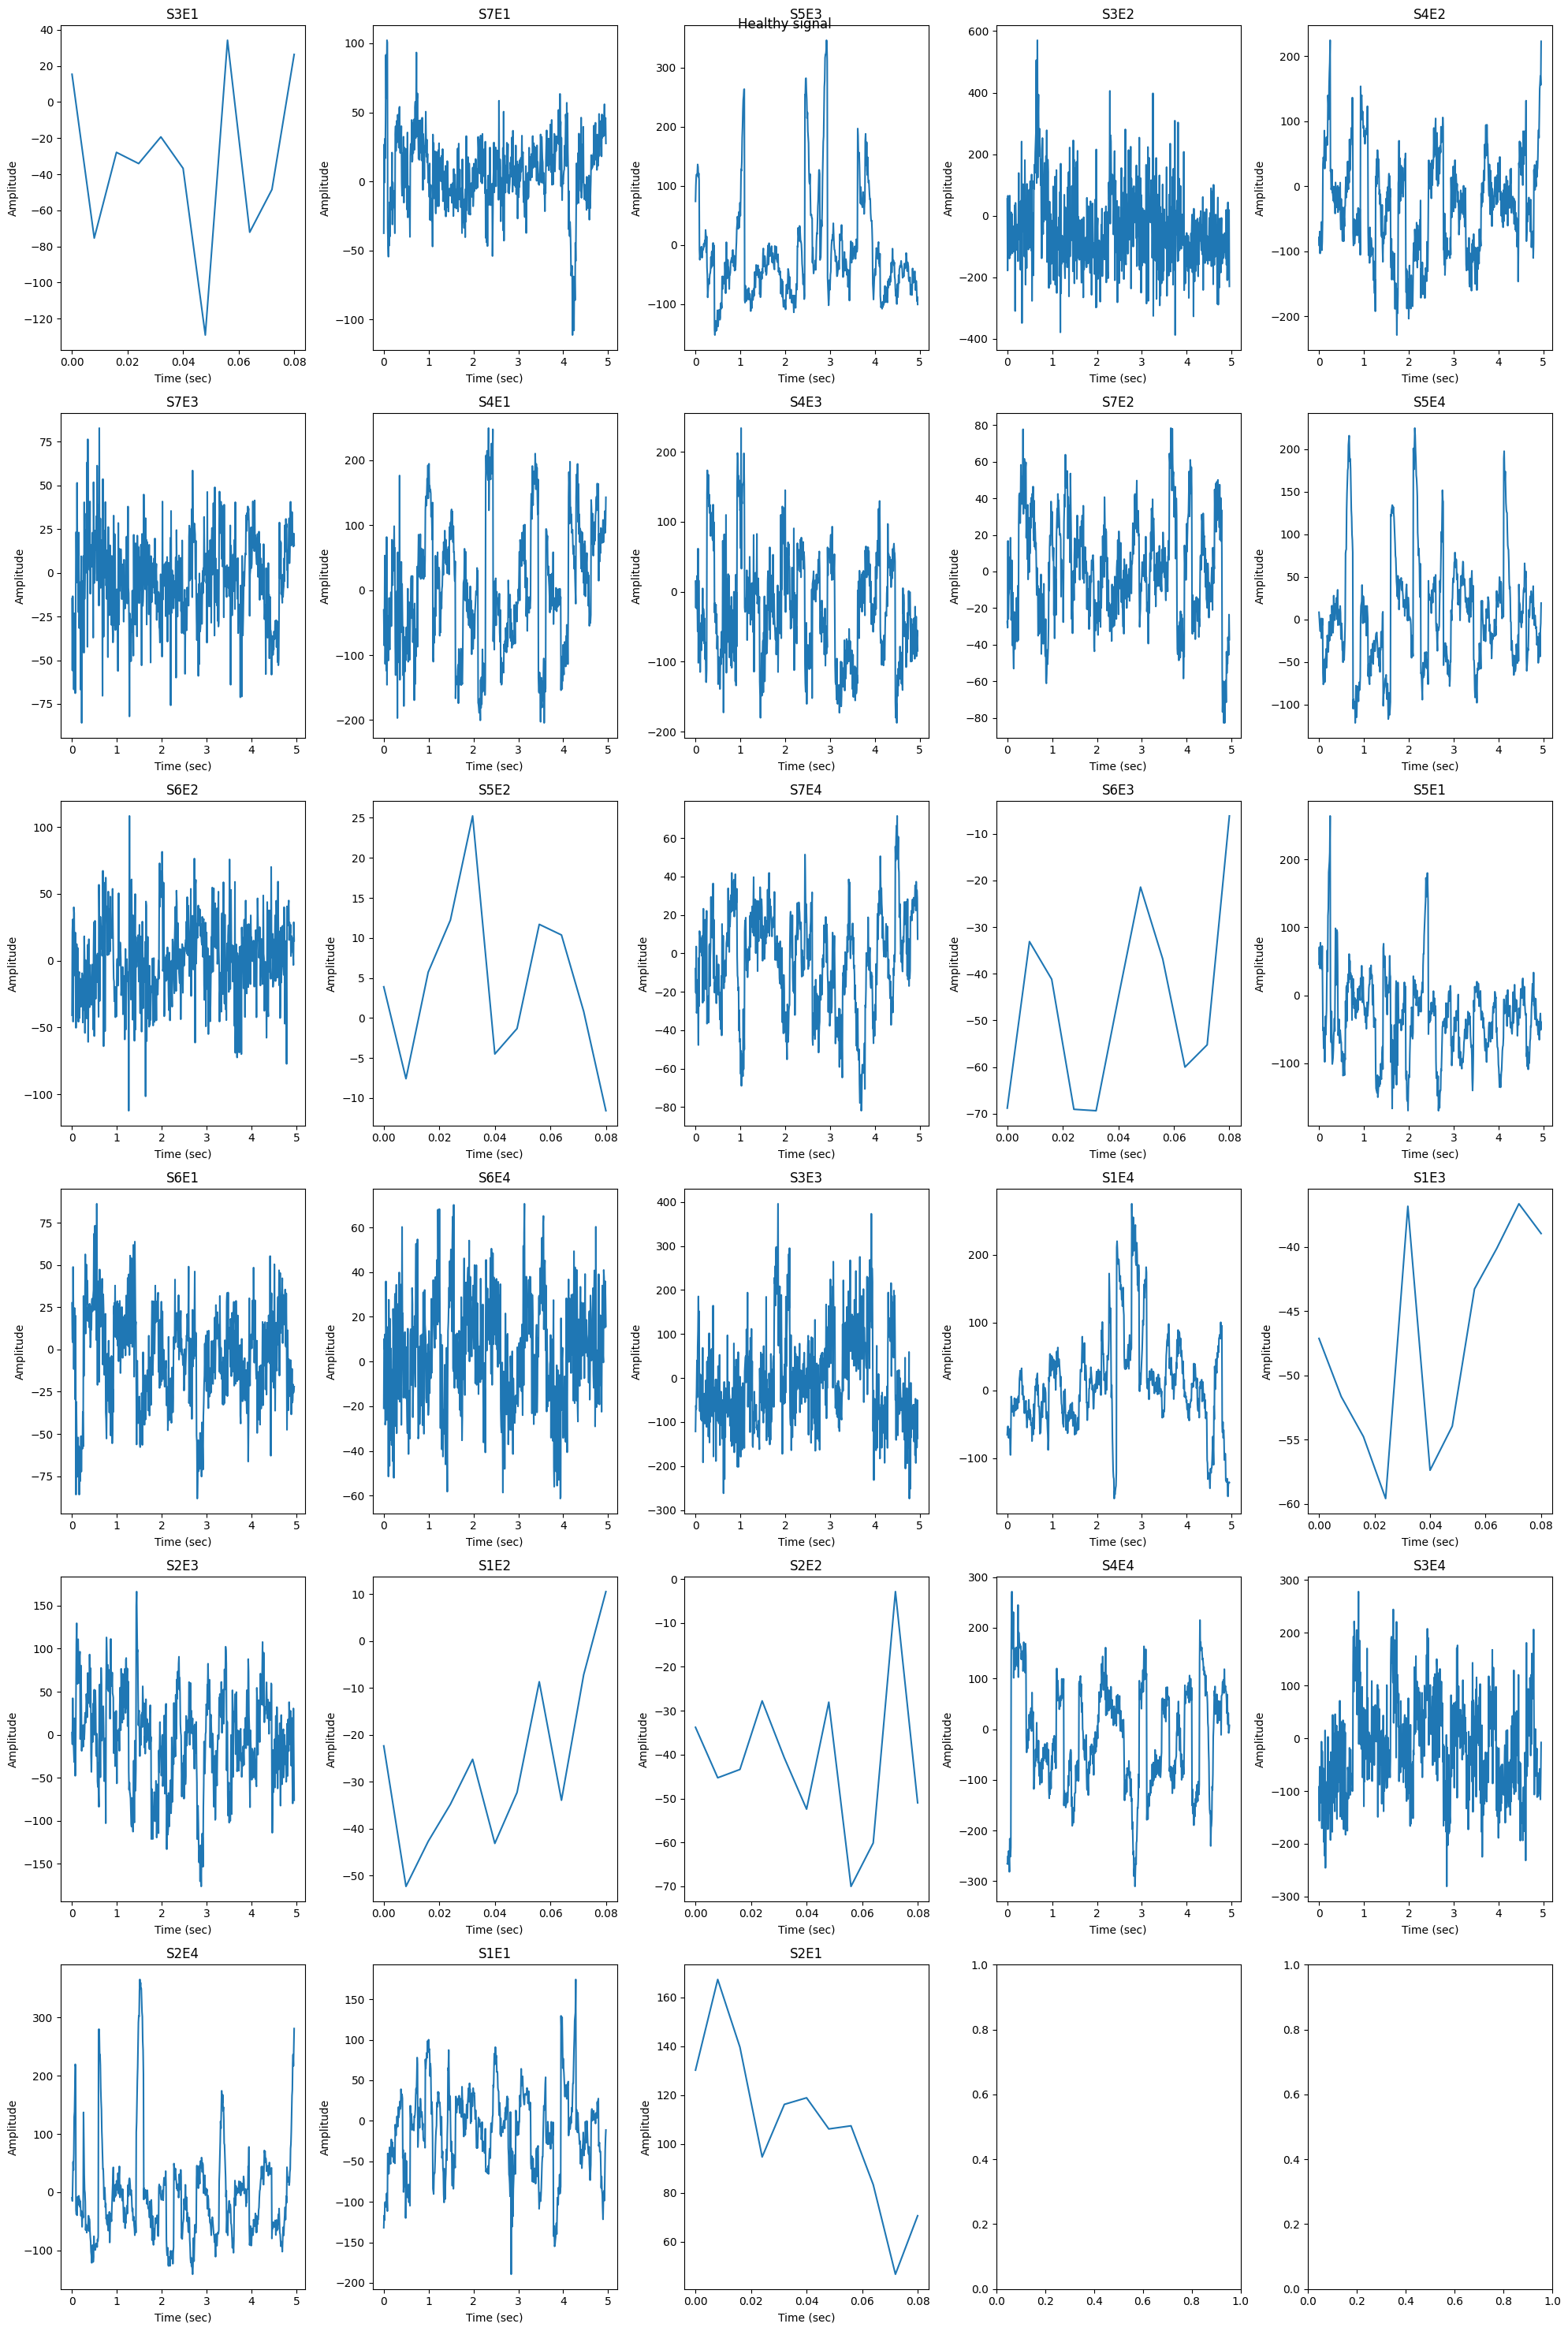

In [ ]:
def df_to_tensor_with_skip(df, label=None):
    # Skip the first row of the DataFrame
    df = df.iloc[1:]
    # Convert DataFrame to NumPy array with float32 dtype
    array = np.array(df, dtype=np.float32)
    # Convert NumPy array to tensor
    tensor = torch.tensor(array, device=device)

    return tensor, label

#Convert tensor with label
def convert_to_tensors_with_labels_with_skip(dataframes, labels):
    tensors_with_labels = []
    for df, label in zip(dataframes, labels):
        tensor, labeled_tensor = df_to_tensor_with_skip(df, label=label)
        tensors_with_labels.append((tensor, labeled_tensor))
    return tensors_with_labels

unhealthy_tensors = convert_to_tensors_with_labels_with_skip(unhealthy_dataframe, labels_unhealthy[:len(unhealthy_dataframe)])
healthy_tensors = convert_to_tensors_with_labels_with_skip(healthy_dataframe, labels_healthy[:len(healthy_dataframe)])

Fs = 125
Ts = 1.0/Fs

def plot_random_signal(tensor_list, title):
    num_signals = len(tensor_list)
    num_cols = 5  # Number of columns in each row
    num_rows = (num_signals + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    fig.suptitle(title)

    for i, (tensor, label) in enumerate(tensor_list):
        row = i // num_cols
        col = i % num_cols
        sig_len = len(tensor[:, 0].detach().cpu().numpy()) / Fs
        t = np.arange(0, sig_len, Ts)

        ax = axes[row, col]
        ax.plot(t, tensor[:, 0].detach().cpu().numpy())
        ax.set_title(label)
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

plot_random_signal(unhealthy_tensors, 'Unhealthy signal')
plot_random_signal(healthy_tensors, 'Healthy signal')

Preprocessing signals

In [ ]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import mne
from mne.filter import filter_data

fs = 125  # Sampling frequency in Hz
low_freq = 8  #Hz
high_freq = 30  #Hz


# Function to apply bandpass filter to EEG signals
def apply_bandpass_filter(df, low_freq, high_freq, fs):
    # Extract channel names from the first row
    ch_names = df.iloc[0].tolist()
    #remove the first row contain the channel row
    df = df.iloc[1:]
    # Convert DataFrame to MNE Raw object
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
    raw = mne.io.RawArray(df.values.T, info)

    # Apply bandpass filter using MNE-Python
    raw.filter(l_freq=low_freq, h_freq=high_freq)

    # Append the filtered channel names after the first row
    df = pd.concat([df.head(1), pd.DataFrame([raw.ch_names], columns=df.columns), df[1:]], ignore_index=True)

    #extract filtered data
    filtered_data = raw.get_data().T
    # Convert back to DataFrame
    df_filtered = pd.DataFrame(data=filtered_data, columns=ch_names)

    return df_filtered

# Apply the bandpass filter to each DataFrame
unhealthy_dataframe = [apply_bandpass_filter(df, low_freq, high_freq, fs) for df in unhealthy_dataframe]

healthy_dataframe = [apply_bandpass_filter(df, low_freq, high_freq, fs) for df in healthy_dataframe]

#Print each dataframe
print_dataframes_with_labels(unhealthy_dataframe, labels_unhealthy)
print_dataframes_with_labels(healthy_dataframe, labels_healthy)

Creating RawArray with float64 data, n_channels=15, n_times=1995
    Range : 0 ... 1994 =      0.000 ...    15.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=15, n_times=6835
    Range : 0 ... 6834 =      0.000 ...    54.672 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=16, n_times=5292
    Range : 0 ... 5291 =      0.000 ...    42.328 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=16, n_times=5943
    Range : 0 ... 5942 =      0.000 ...    47.536 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=17, n_times=6111
    Range : 0 ... 6110 =      0.000 ...    48.880 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=14, n_times=6216
    Range : 0 ... 6215 =      0.000 ...    49.720 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Range : 0 ... 6068 =      0.000 ...    48.544 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=17, n_times=5208
    Range : 0 ... 5207 =      0.000 ...    41.656 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=16, n_times=5334
    Range : 0 ... 5333 =      0.000 ...    42.664 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=11
    Range : 0 ... 10 =      0.000 ...     0.080 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filte

<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filte

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=11
    Range : 0 ... 10 =      0.000 ...     0.080 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transit

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=11
    Range : 0 ... 10 =      0.000 ...     0.080 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Creating RawArray with float64 data, n_channels=18, n_times=11
    Range : 0 ... 10 =      0.000 ...     0.080 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=11
    Range : 0 ... 10 =      0.000 ...     0.080 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Ra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Creating RawArray with float64 data, n_channels=18, n_times=620
    Range : 0 ... 619 =      0.000 ...     4.952 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff freque

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 207 samples (1.656 s)

Label: S4E2
Dataframe:
                C3            C4            Cz           CP1           CP2  \
0    -2.220446e-16  8.881784e-16  5.551115e-16  1.110223e-15  9.992007e-16   
1     3.076143e-01  7.627608e+00  3.879955e-02  2.931364e-01  1.564572e+00   
2    -2.961425e-02  6.629268e+00  4.685224e-01  1.677243e-01  1.918029e+00   
3    -4.046268e-01  1.170171e+00  5.121211e-01 -5.467525e-01  3.574442e-01   
4    -3.732455e-01 -5.965882e-01 -1.060556e-01 -1.245405e+00 -1.572268e+00   
...            ...           ...           ...           .

<ipython-input-9-547c7ccdc000>:22: RuntimeWarning: filter_length (207) is longer than the signal (11), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


                C3            C4            Cz           CP1           CP2  \
0     2.664535e-15  1.609823e-15  0.000000e+00  1.332268e-15  8.881784e-16   
1    -6.152160e+00 -2.985473e+00 -3.651606e+00 -4.243561e+00 -3.742400e+00   
2    -5.101237e+00 -1.992111e+00 -1.278415e+00 -3.453140e+00 -1.482538e+00   
3    -1.249312e+00 -2.153745e-01  2.682955e+00 -8.845869e-01  2.342339e+00   
4    -1.034626e+00 -1.267525e+00  2.026413e+00 -9.470120e-01  1.633646e+00   
...            ...           ...           ...           ...           ...   
5707  5.258406e-01  3.054819e+00 -2.870640e+00 -5.558563e-01  8.185997e-01   
5708  7.859460e-02  2.998607e+00 -3.200191e+00 -1.222184e+00  3.902089e-01   
5709  1.021325e+00  1.280312e+00 -2.471311e+00  2.462098e+00  6.236947e-01   
5710  1.820901e+00  1.336509e-01 -1.001264e+00  4.696321e+00  9.767781e-01   
5711 -9.853229e-16 -2.081668e-17 -4.440892e-16 -7.216450e-16 -4.163336e-16   

               CP5           CP6           FC1           FC2   

Normalization

In [ ]:
#function in order to normalize the data
def normalize_dataframes(dataframes_list):

    normalized_dataframes = []

    for df in dataframes_list:
        # Apply Min-Max scaling to normalize values between [0, 1]
        normalized_df = (df - df.min()) / (df.max() - df.min())
        normalized_dataframes.append(normalized_df)

    return normalized_dataframes

unhealthy_dataframe=normalize_dataframes(unhealthy_dataframe)

healthy_dataframe=normalize_dataframes(healthy_dataframe)

#Print each dataframe
print(f"---------UNHEALTHY:{len(unhealthy_dataframe)} Dataframe ---------")
print_dataframes_with_labels(unhealthy_dataframe, labels_unhealthy)
print("\n")
print(f"---------HEALTHY:{len(healthy_dataframe)} Dataframe ---------")
print_dataframes_with_labels(healthy_dataframe, labels_healthy)

---------UNHEALTHY:21 Dataframe ---------
Label: S4E2
Dataframe:
            C3        C4        Cz       CP1       CP2       CP5       CP6  \
0     0.527677  0.486394  0.507716  0.532539  0.484580  0.557709  0.499006   
1     0.542594  0.692270  0.510990  0.548218  0.587627  0.591602  0.936204   
2     0.526241  0.665324  0.547248  0.541510  0.610907  0.548158  0.892538   
3     0.508056  0.517978  0.550926  0.503295  0.508122  0.502991  0.570629   
4     0.509577  0.470292  0.498768  0.465925  0.381025  0.521829  0.450567   
...        ...       ...       ...       ...       ...       ...       ...   
1990  0.408495  0.430573  0.380814  0.378447  0.368127  0.430863  0.330091   
1991  0.290896  0.413716  0.236270  0.230479  0.213399  0.310961  0.242749   
1992  0.230815  0.458066  0.255772  0.171532  0.236958  0.262083  0.353367   
1993  0.325163  0.498163  0.399340  0.295735  0.383664  0.361848  0.495616   
1994  0.527677  0.486394  0.507716  0.532539  0.484580  0.557709  0.499006   

Transform to tensor

In [ ]:
def df_to_tensor(df, label=None):
    # Convert DataFrame to NumPy array with float32 dtype
    array = np.array(df, dtype=np.float32)

    # Convert NumPy array to tensor
    tensor = torch.tensor(array)

    return tensor, label

#Convert tensor with label
def convert_to_tensors_with_labels(dataframes, labels):
    tensors_with_labels = []
    for df, label in zip(dataframes, labels):
        tensor, labeled_tensor = df_to_tensor(df, label=label)
        tensors_with_labels.append((tensor, labeled_tensor))
    return tensors_with_labels

unhealthy_tensors = convert_to_tensors_with_labels(unhealthy_dataframe, labels_unhealthy[:len(unhealthy_dataframe)])
healthy_tensors = convert_to_tensors_with_labels(healthy_dataframe, labels_healthy[:len(healthy_dataframe)])

# Print the tensors with labels and shapes
print(f"---------UNHEALTHY:{len(unhealthy_tensors)} Tensor---------")
for tensor, label in unhealthy_tensors:
    print("Label:", label)
    print("Tensor Shape:", tensor.shape)
    print("Tensor:")
    print(tensor)
    print("------------------")

print("\n")

print(f"---------HEALTHY:{len(healthy_tensors)} Tensor---------")
for tensor, label in healthy_tensors:
    print("Label:", label)
    print("Tensor Shape:", tensor.shape)
    print("Tensor:")
    print(tensor)
    print("------------------")

---------UNHEALTHY:21 Tensor---------
Label: S4E2
Tensor Shape: torch.Size([1995, 15])
Tensor:
tensor([[0.5277, 0.4864, 0.5077,  ..., 0.5322, 0.4815, 0.5043],
        [0.5426, 0.6923, 0.5110,  ..., 0.5695, 0.6312, 0.6301],
        [0.5262, 0.6653, 0.5472,  ..., 0.5369, 0.6575, 0.6086],
        ...,
        [0.2308, 0.4581, 0.2558,  ..., 0.1763, 0.2863, 0.1381],
        [0.3252, 0.4982, 0.3993,  ..., 0.2950, 0.4189, 0.2743],
        [0.5277, 0.4864, 0.5077,  ..., 0.5322, 0.4815, 0.5043]])
------------------
Label: S3E3
Tensor Shape: torch.Size([6835, 15])
Tensor:
tensor([[0.5065, 0.4300, 0.4677,  ..., 0.5147, 0.4374, 0.5329],
        [0.4216, 0.3478, 0.3299,  ..., 0.4903, 0.4117, 0.5136],
        [0.4932, 0.3722, 0.3943,  ..., 0.5061, 0.4145, 0.5755],
        ...,
        [0.4179, 0.3220, 0.4694,  ..., 0.4923, 0.4915, 0.5788],
        [0.3551, 0.3028, 0.4442,  ..., 0.4596, 0.4572, 0.5432],
        [0.5065, 0.4300, 0.4677,  ..., 0.5147, 0.4374, 0.5329]])
------------------
Label: S5E3
Te

###Plot the signal after apply Band Pass filter

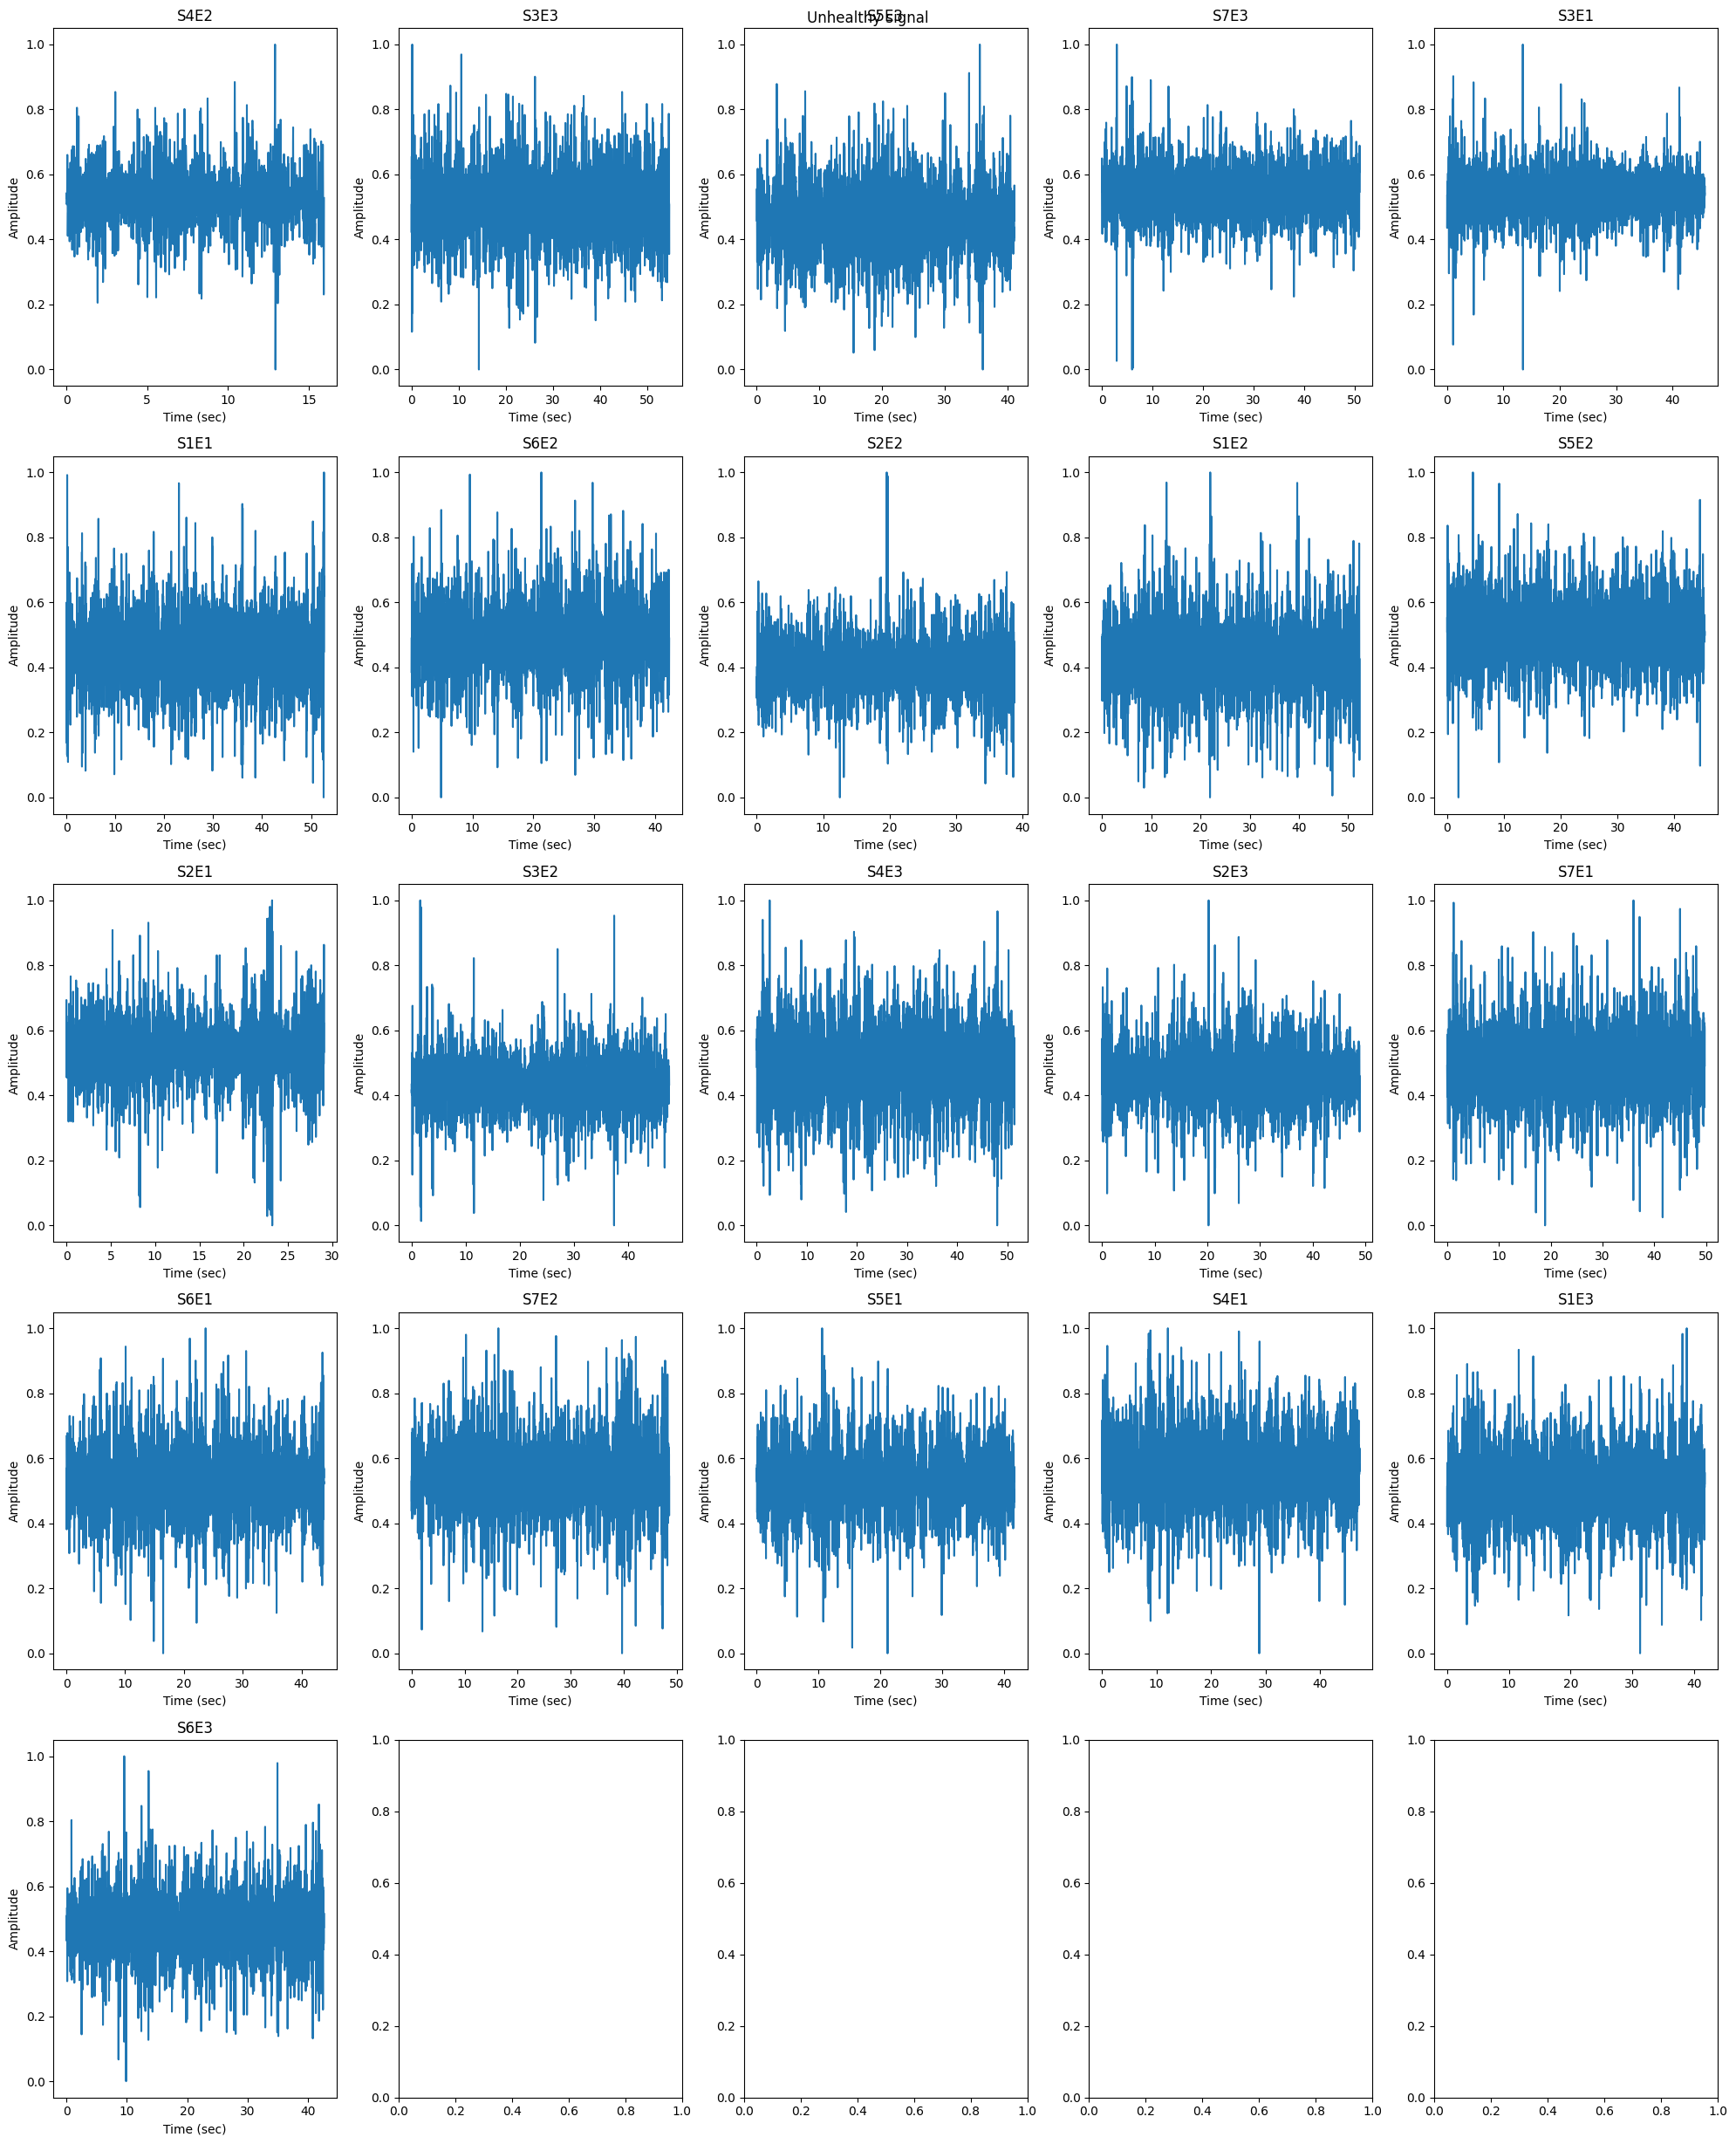

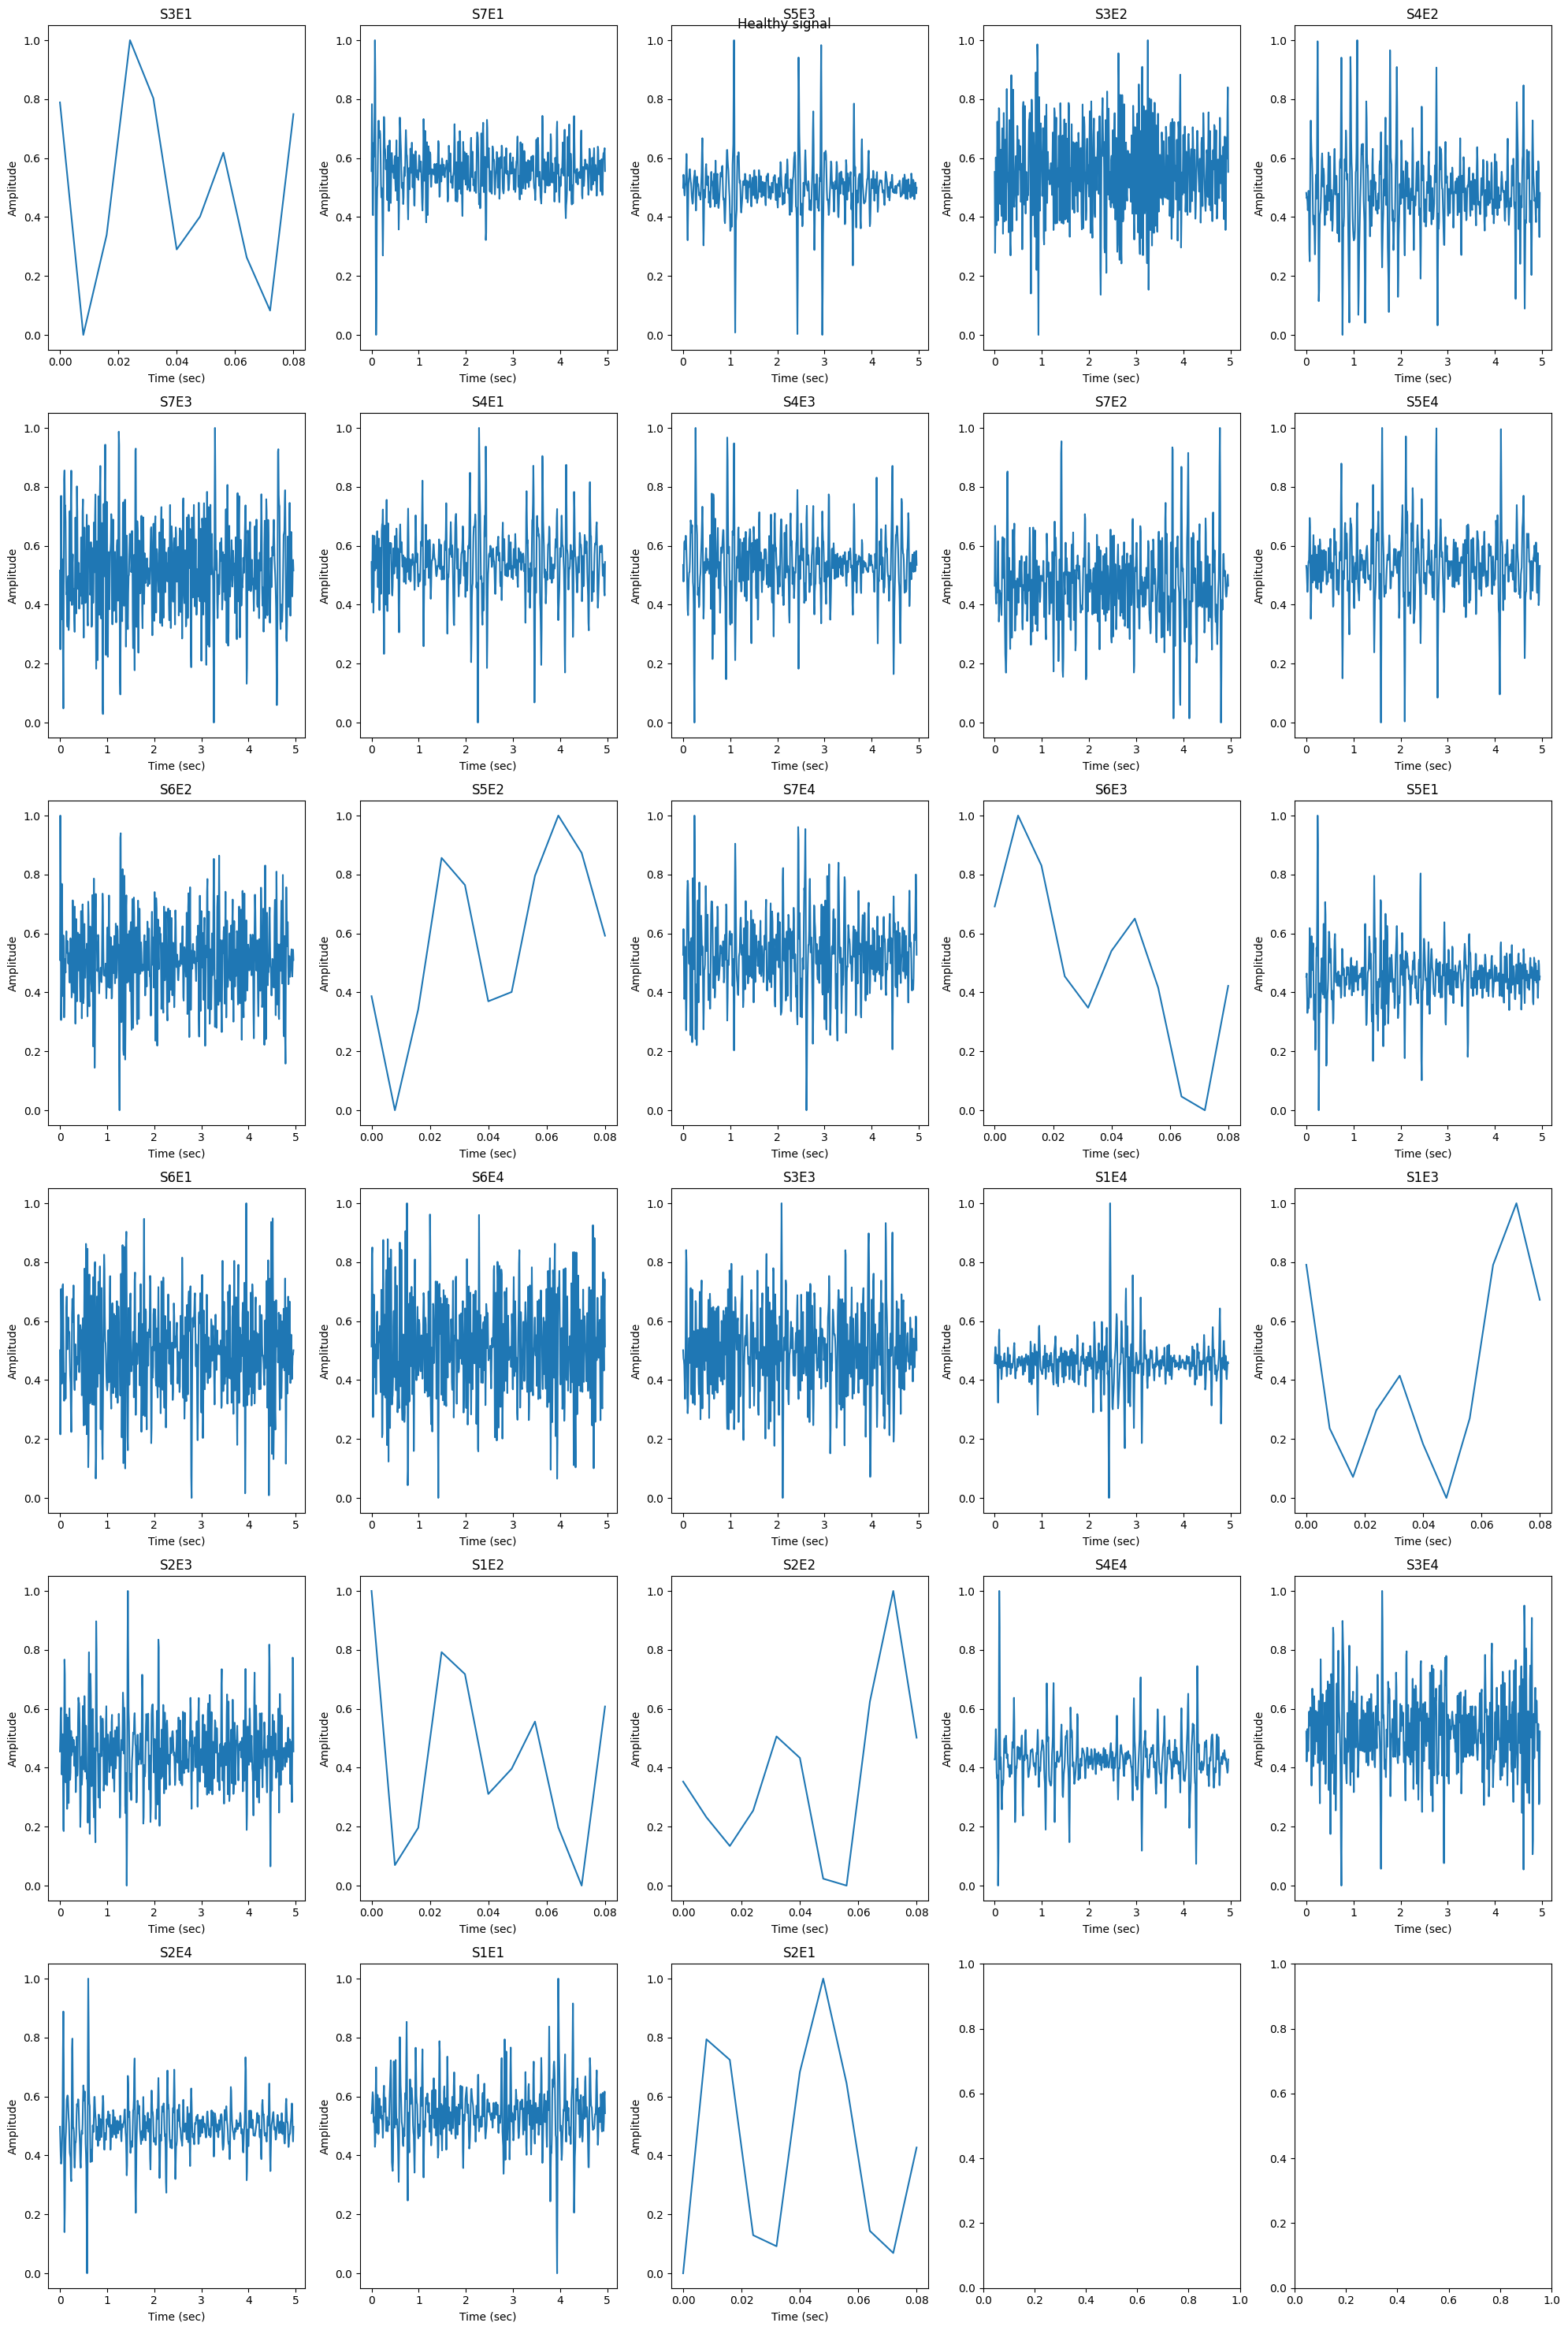

In [ ]:
import random

Fs = 125
Ts = 1.0/Fs

def plot_random_signal(tensor_list, title):
    num_signals = len(tensor_list)
    num_cols = 5  # Number of columns in each row
    num_rows = (num_signals + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    fig.suptitle(title)

    for i, (tensor, label) in enumerate(tensor_list):
        row = i // num_cols
        col = i % num_cols
        sig_len = len(tensor[:, 0].detach().cpu().numpy()) / Fs
        t = np.arange(0, sig_len, Ts)

        ax = axes[row, col]
        ax.plot(t, tensor[:, 0].detach().cpu().numpy())
        ax.set_title(label)
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

plot_random_signal(unhealthy_tensors, 'Unhealthy signal')
plot_random_signal(healthy_tensors, 'Healthy signal')

###Filter tensor which have less common shape and set a common shape for this tensor in order to make similarity from each other

In [ ]:
def filter_tensors(labeled_tensors, threshold_shape):
    filtered_tensors = []
    for tensor, label in labeled_tensors:
        if tensor.shape[0] >= threshold_shape[0] and tensor.shape[1] >= threshold_shape[1]:
            # If tensor shape is larger than threshold, resize or crop it
            tensor_filtered = tensor[:threshold_shape[0], :threshold_shape[1]]

            filtered_tensors.append((tensor_filtered, label))

    return filtered_tensors

# Define the threshold shape
threshold_unhealthy = (619, 15)
threshold_healthy = (619, 15)

unhealthy_tensors = filter_tensors(unhealthy_tensors, threshold_unhealthy)
healthy_tensors = filter_tensors(healthy_tensors, threshold_healthy)

# Print the tensors with labels and shapes
print(f"---------UNHEALTHY:{len(unhealthy_tensors)} Tensor---------")
for tensor, label in unhealthy_tensors:
    print("Label:", label)
    print("Tensor Shape:", tensor.shape)
    print("Tensor:")
    print(tensor)
    print("------------------")

print("\n")

print(f"---------HEALTHY:{len(healthy_tensors)} Tensor---------")
for tensor, label in healthy_tensors:
    print("Label:", label)
    print("Tensor Shape:", tensor.shape)
    print("Tensor:")
    print(tensor)
    print("------------------")

---------UNHEALTHY:17 Tensor---------
Label: S4E2
Tensor Shape: torch.Size([619, 15])
Tensor:
tensor([[0.5277, 0.4864, 0.5077,  ..., 0.5322, 0.4815, 0.5043],
        [0.5426, 0.6923, 0.5110,  ..., 0.5695, 0.6312, 0.6301],
        [0.5262, 0.6653, 0.5472,  ..., 0.5369, 0.6575, 0.6086],
        ...,
        [0.6474, 0.5872, 0.6601,  ..., 0.6207, 0.6160, 0.6200],
        [0.6616, 0.5525, 0.6082,  ..., 0.6477, 0.6206, 0.6343],
        [0.4627, 0.4610, 0.4270,  ..., 0.4390, 0.3995, 0.4195]])
------------------
Label: S3E3
Tensor Shape: torch.Size([619, 15])
Tensor:
tensor([[0.5065, 0.4300, 0.4677,  ..., 0.5147, 0.4374, 0.5329],
        [0.4216, 0.3478, 0.3299,  ..., 0.4903, 0.4117, 0.5136],
        [0.4932, 0.3722, 0.3943,  ..., 0.5061, 0.4145, 0.5755],
        ...,
        [0.5464, 0.3928, 0.6204,  ..., 0.4950, 0.3514, 0.6829],
        [0.5514, 0.3953, 0.6421,  ..., 0.4889, 0.3543, 0.6950],
        [0.5515, 0.3893, 0.5797,  ..., 0.5311, 0.3853, 0.6175]])
------------------
Label: S5E3
Tens

#Save and load tensor

In [ ]:
# Saving the lists to a file
#path='/content/drive/Othercomputers/Il mio computer/AI & Robotics/Project/Napoli/Saves/Signal_tensors'

path= '/OneDrive/Desktop/AI & Robotics/Project/Napoli/Saves/Signal_tensors'

#torch.save(unhealthy_tensors, path+'unhealthy_tensors.pt')
#torch.save(healthy_tensors, path+'healthy_tensors.pt')

# Loading the lists from the file
unhealthy = torch.load(path+'/unhealthy_tensors.pt')
healthy = torch.load(path+'/healthy_tensors.pt')

FileNotFoundError: [Errno 2] No such file or directory: '/OneDrive/Desktop/AI & Robotics/Project/Napoli/Saves/Signal_tensors/unhealthy_tensors.pt'

###Dataloader

In [ ]:
unhealthy_tensor_train, unhealthy_tensor_test = train_test_split(unhealthy, test_size=0.2, random_state=42)
healthy_tensor_train, healthy_tensor_test = train_test_split(healthy, test_size=0.2, random_state=42)

In [ ]:
#Create a DataLoader for the training unhealthy and healthy data
batch_size = 32

unhealthy_loader_train = DataLoader(unhealthy_tensor_train, batch_size=batch_size, shuffle=True)
unhealthy_loader_test = DataLoader(unhealthy_tensor_test, batch_size=batch_size, shuffle=True)
healthy_loader_train = DataLoader(healthy_tensor_train, batch_size=batch_size, shuffle=True)
healthy_loader_test = DataLoader(healthy_tensor_test, batch_size=batch_size, shuffle=True)

#cGAN

GENERATOR

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=30, num_layers=1, apply_tanh=False, dropout=0.2):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.apply_tanh = apply_tanh
        if apply_tanh:
            self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :])
        if self.apply_tanh:
            out = self.tanh(out)
        return out

DISCRIMINATOR

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size, seq_len):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.fc = nn.Linear(512*seq_len, 1)
        self.relu = nn.ReLU(0.02)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        #x = self.pool1(x)
        x = self.relu(self.conv2(x))
        #x = self.pool2(x)
        x = self.relu(self.conv3(x))
        #x = self.pool3(x)
        x = self.relu(self.conv4(x))
        #x = self.pool4(x)
        x = torch.flatten(x)
        x = self.fc(x)
        return self.sigmoid(x)

#Training

###GAN

In [ ]:
save_path= '/content/drive/Othercomputers/Il mio computer/AI & Robotics/Project/Napoli/Saves/GAN'

def train_EEGgan(generator, discriminator, noisy_dataloader, clean_dataloader, num_epochs=100, lr=0.0002):

    criterion = nn.MSELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Set models to evaluation mode
    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        for (noisy, _), (clean, _) in zip(noisy_dataloader, clean_dataloader):

            # Set model input
            clean_eeg = clean[0] #--> Clean Signals
            noisy_eeg = noisy[0] #--> Noisy Signals

            # Adversarial GT
            real_labels = torch.ones(1).to(device)
            fake_labels = torch.zeros(1).to(device)

            #Train Generator
            optimizer_g.zero_grad()
            denoised_data = generator(noisy_eeg.unsqueeze(0)).to(device).detach()

            # Loss measures generator's ability to fool the discriminator
            outputs = discriminator(denoised_data.permute(1, 2, 0)).to(device)
            loss_G= criterion(outputs, real_labels)
            loss_G.backward()
            optimizer_g.step()

            #Train Discriminator
            optimizer_d.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_outputs = discriminator(clean_eeg.unsqueeze(2)).to(device)
            d_loss_real = criterion(real_outputs, real_labels)
            fake_outputs = discriminator(denoised_data.permute(1, 2, 0)).to(device)
            d_loss_fake = criterion(fake_outputs, fake_labels)

            loss_D = (0.5 * (d_loss_real + d_loss_fake))

            loss_D.backward()
            optimizer_d.step()


        # Print losses
        print(f"Epoch [{epoch}/{num_epochs}], Generator Loss: {loss_G.item():.4f}, Discriminator Loss: {loss_D:.4f}")

        # Save weights and parameters after each epoch
        #torch.save(generator.state_dict(), os.path.join(save_path+'/Gen/', f"generator_epoch_{epoch}.pt"))
        #torch.save(discriminator.state_dict(), os.path.join(save_path+'/Disc/', f"discriminator_epoch_{epoch}.pt"))

###WGAN

In [ ]:
import torch.nn.functional as F

save_path= '/content/drive/Othercomputers/Il mio computer/AI & Robotics/Project/Napoli/Saves/WGAN'

def train_WGAN(generator, discriminator, noisy_dataloader, clean_dataloader, num_epochs=100, lr=0.00005, clip_value=0.01):
    optimizer_g = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_d = optim.RMSprop(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for (noisy, _), (clean, _) in zip(noisy_dataloader, clean_dataloader):
            clean_eeg = clean[0] # Clean Signals
            noisy_eeg = noisy[0] # Noisy Signals

            # Train Discriminator
            for d_iter in range(5):  # Train discriminator more than the generator
                optimizer_d.zero_grad()

                # Weight clipping (clip discriminator parameters)
                for p in discriminator.parameters():
                    p.data.clamp_(-clip_value, clip_value)

                # Generate fake data
                with torch.no_grad():
                    denoised_data = generator(noisy_eeg.unsqueeze(0)).to(device).detach()

                # Wasserstein loss - negative because we want to maximize it
                d_loss_real= torch.mean(discriminator(clean_eeg.unsqueeze(2)))
                d_loss_fake= torch.mean(discriminator(denoised_data.permute(1, 2, 0)))

                d_loss = d_loss_real - d_loss_fake

                d_loss.backward()
                optimizer_d.step()

                #print(f'  Discriminator iteration: {d_iter}/{5}, loss_fake: {d_loss_fake.item()}, loss_real: {d_loss_real.item()}')


            # Train Generator
            optimizer_g.zero_grad()
            denoised_data = generator(noisy_eeg.unsqueeze(0)).to(device)

            # Generator loss
            g_loss = -torch.mean(discriminator(denoised_data.permute(1, 2, 0)))

            g_loss.backward()
            optimizer_g.step()

        # Print losses
        print(f"Epoch [{epoch}/{num_epochs}], Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

        # Save weights and parameters after each epoch
        #torch.save(generator.state_dict(), os.path.join(save_path+'/Gen/', f"generator_epoch_{epoch}.pt"))
        #torch.save(discriminator.state_dict(), os.path.join(save_path+'/Disc/', f"discriminator_epoch_{epoch}.pt"))

In [ ]:
input_size = 15 #channel of the each signal
output_size = 15
seq_len=619
num_epochs = 10
apply_tanh=False

generator = Generator(input_size, output_size, apply_tanh=apply_tanh).to(device)
discriminator = Discriminator(input_size, seq_len).to(device)

#Train the model
#train_EEGgan(generator, discriminator, unhealthy_loader_train, healthy_loader_train, num_epochs=num_epochs)
train_WGAN(generator, discriminator, unhealthy_loader_train, healthy_loader_train, num_epochs=num_epochs)

Epoch [0/10], Generator Loss: -0.4729, Discriminator Loss: -0.0019
Epoch [1/10], Generator Loss: -0.5891, Discriminator Loss: -0.0185
Epoch [2/10], Generator Loss: -0.4393, Discriminator Loss: -0.0660
Epoch [3/10], Generator Loss: -0.7036, Discriminator Loss: -0.1603
Epoch [4/10], Generator Loss: -0.5547, Discriminator Loss: -0.2901
Epoch [5/10], Generator Loss: -0.8202, Discriminator Loss: -0.4465
Epoch [6/10], Generator Loss: -0.7685, Discriminator Loss: -0.5862
Epoch [7/10], Generator Loss: -0.8920, Discriminator Loss: -0.7346
Epoch [8/10], Generator Loss: -0.9103, Discriminator Loss: -0.8049
Epoch [9/10], Generator Loss: -0.9408, Discriminator Loss: -0.8691


#Testing the Trained EEG Denoising model

###GAN test

In [ ]:
def test_EEGgan(generator, noisy_dataloader, clean_dataloader):

    # Set models to evaluation mode
    generator.eval()

    for (noisy, _), (clean, _) in zip(noisy_dataloader, clean_dataloader):

        clean_eeg = clean[0].to(device)
        noisy_eeg = noisy[0].to(device)

        denoised_signal = generator(noisy_eeg.unsqueeze(0)).to(device).detach().squeeze(0)

    return clean_eeg, noisy_eeg, denoised_signal

###WGAN test

In [ ]:
def test_WGAN(generator, noisy_dataloader, clean_dataloader):

    # Set models to evaluation mode
    generator.eval()

    for (noisy, _), (clean, _) in zip(noisy_dataloader, clean_dataloader):

        clean_eeg = clean[0].to(device)
        noisy_eeg = noisy[0].to(device)

        denoised_signal = generator(noisy_eeg.unsqueeze(0)).to(device).detach().squeeze(0)

    return clean_eeg, noisy_eeg, denoised_signal

In [ ]:
input_size = 15
output_size = 15
seq_len= 619 #time step of the each signal
apply_tanh=False

#load the model
generator = Generator(input_size, output_size, apply_tanh=apply_tanh).to(device)

#load the parameters
#generator.load_state_dict(torch.load(save_path+'/Gen/generator_epoch_99.pt'))

#clean_eeg, noisy_eeg, cleaned_eeg = test_EEGgan(generator, unhealthy_loader_test, healthy_loader_test)
clean_eeg, noisy_eeg, cleaned_eeg = test_WGAN(generator, unhealthy_loader_test, healthy_loader_test)

###Plot the cleaned test signal

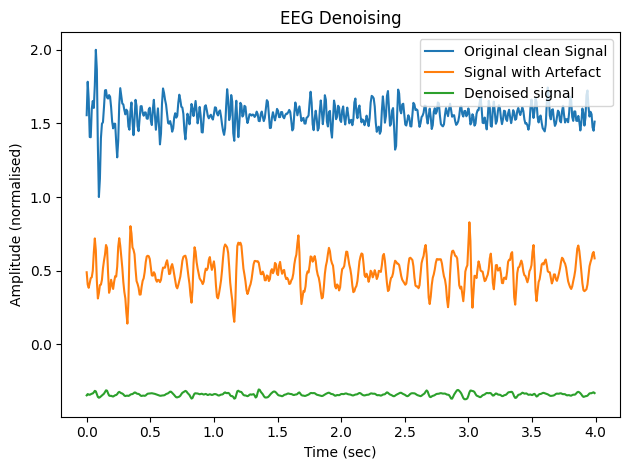

In [ ]:
Fs = 125
Ts = 1.0/Fs
sig_len = len(clean_eeg[:,0].detach().cpu().numpy())//Fs
t = np.arange(0, sig_len, Ts)
plt.plot(t, clean_eeg[:500,0].detach().cpu().numpy()+ 1.0, label = 'Original clean Signal')
plt.plot(t, noisy_eeg[:500,0].detach().cpu().numpy(), label = 'Signal with Artefact')
plt.plot(t, cleaned_eeg[:500,0].detach().cpu().numpy() - 0.5, label = 'Denoised signal' )
plt.title('EEG Denoising')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (normalised)')
plt.legend()
plt.tight_layout()